# HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS
Data set from kaggle: https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis

In [93]:
%%capture
%pip install graphdatascience pandas ipython numpy

In [94]:
import pandas as pd
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience
import numpy as np

In [95]:
# Neo4j Sandbox Connection details
DB_ULR = 'neo4j://localhost:7687'
DB_USER = 'neo4j'
DB_PASS = 'test1234'
gds = GraphDataScience.from_neo4j_driver(DB_ULR, auth=(DB_USER, DB_PASS))
gds.version()

'2.2.2'

In [7]:
# Provider
train_provider_csv = pd.read_csv("./datasets/Train-1542865627584.csv")
train_provider_csv.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [19]:
# Create Provider nodes
gds.run_cypher('create constraint if not exists for (n:Provider) require (n.id) is node key')
label_dist = gds.run_cypher('''
    unwind $data as row
    merge (n:Provider{id: row.Provider})
        set n.fraud = case row.PotentialFraud when 'Yes' then true else false end
    return n.fraud as is_fraud, count(*) as count
''', params = {'data': train_provider_csv.to_dict('records')})
label_dist.head()

,is_fraud,count
0,False,4904
1,True,506


In [23]:
# Beneficiarydata
pd.set_option('display.max_columns', None)
train_beneficiary_csv = pd.read_csv("./datasets/Train_Beneficiarydata-1542865627584.csv")
train_beneficiary_csv.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


In [27]:
train_beneficiary_csv.columns


Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')

In [31]:
gds.run_cypher('create constraint if not exists for (n:Condition) require (n.id) is node key')
gds.run_cypher('''
    unwind [
        'RenalDiseaseIndicator',
        'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
        'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
        'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
        'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
        'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
        'ChronicCond_stroke'
    ] as conditionId
    merge (n:Condition{id: conditionId})
''')

""


In [80]:
# Create Beneficiary nodes and also has_condition relationships
gds.run_cypher('create constraint if not exists for (n:Beneficiary) require (n.id) is node key')
gds.run_cypher('''
    match (c:Condition)
    with collect(c) as conditions
    unwind $data as row
    merge (n:Beneficiary{id: row.BeneID})
        set n.dob = date(row.DOB),
            n.gender = row.Gender,
            n.race = row.Race
    with conditions, n, row
    call {
        with row, conditions, n
        foreach(
            c in [x in conditions where row[x.id] = 1 or row[x.id] = 'Y' | x] |
            merge (n)-[:has_condition]->(c)
        )
    }
''', params = {'data': train_beneficiary_csv.to_dict('records')})

""


In [48]:
# Set date of death
dead = train_beneficiary_csv[['BeneID','DOD']].dropna()
gds.run_cypher(''' 
    unwind $data as row
    match (n:Beneficiary{id: row.BeneID})
        set n.dod = date(row.DOD)
''', params = {'data': dead.to_dict('records')})

""


array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

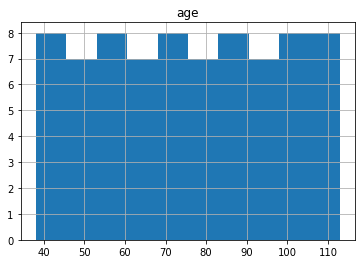

In [58]:
# Compute age of Beneficiaries
agedist = gds.run_cypher(''' 
    with date() as today
    match (n:Beneficiary)
    set n.age = duration.between(n.dob, today).years
    return n.age as age, count(*) as beneficiaries order by age
''')
agedist.hist("age")

In [79]:
# Inpatientdata
pd.set_option('display.max_columns', None)
train_inpatient_csv = pd.read_csv("./datasets/Train_Inpatientdata-1542865627584.csv")
train_inpatient_csv.fillna( value=0, inplace=True)
train_inpatient_csv.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,0,0,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,0,0.0,0.0,0.0,0.0,0.0,0.0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,0,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,0,0,0,0,0,0,0,7092.0,0.0,0.0,0.0,0.0,0.0
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,0,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,0,331.0,0.0,0.0,0.0,0.0,0.0
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,0,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,0,3893.0,0.0,0.0,0.0,0.0,0.0


In [99]:
train_inpatient_csv.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')

In [104]:
# Create claims data
gds.run_cypher('create constraint if not exists for (n:Claim) require (n.id) is node key')
gds.run_cypher('create constraint if not exists for (n:Provider) require (n.id) is node key')
gds.run_cypher('create constraint if not exists for (n:Physician) require (n.id) is node key')
gds.run_cypher('create constraint if not exists for (n:Diagnosis) require (n.id) is node key')
gds.run_cypher('create constraint if not exists for (n:Procedure) require (n.id) is node key')

claims_cypher = '''
    unwind $data as row
    merge (c:Claim{id: row.ClaimID})
        set c.inpatient = $inpatient,
            c.startDate = date(row.ClaimStartDt),
            c.endDate = date(row.ClaimEndDt),
            c.admissionDate = date(row.AdmissionDt),
            c.dischargeDate = date(row.DischargeDt),
            c.deductible_amt = row.DeductibleAmtPaid,
            c.reimbursed_amt = row.InscClaimAmtReimbursed
    merge (p:Provider{id: row.Provider})
    merge (c)-[:provider]->(p)
    merge (b:Beneficiary{id: row.BeneID})
    merge (c)-[:beneficiary]->(b)
    with c,p, row
    call {
        with c,p,row
        with c,p,row where row.ClmAdmitDiagnosisCode <> 0
        merge (d:Diagnosis{id: row.ClmAdmitDiagnosisCode})
        merge (c)-[:admit_diagonisis]->(d)
    }
    call {
        with c,p,row
        with c,p,row where row.DiagnosisGroupCode <> 0
        merge (d:Diagnosis{id: row.DiagnosisGroupCode})
        merge (c)-[:diagonisis_group]->(d)
    }
    call {
        with c,p,row
        with c,p, [ x in  [ 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                            'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
                            'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
                            'ClmDiagnosisCode_10' ] where row[x] <> 0 |
                   row[x]] as codes
        foreach( code in codes | 
            merge (d:Diagnosis{id: code})
            merge (c)-[:diagonisis_code]->(d)
        )
    }
    call {
        with c,p,row
        with c,p, [ x in  [ 'ClmProcedureCode_1', 'ClmProcedureCode_2',
                            'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
                            'ClmProcedureCode_6' ] where row[x] <> 0 |
                   row[x]] as codes
        foreach( code in codes | 
            merge (d:Procedure{id: code})
            merge (c)-[:procedure_code]->(d)
        )
    }
    call {
        with c,p,row
        with c,p,row where row.AttendingPhysician <> 0 
        merge (ap:Physician{id: row.AttendingPhysician})
        merge (c)-[:attending]->(ap)
    }
    call {
        with c,p,row
        with c,p,row where row.OperatingPhysician <> 0 
        merge (op:Physician{id: row.OperatingPhysician})
        merge (c)-[:operating]->(op)
    }
    call {
        with c,p,row
        with c,p,row where row.OtherPhysician <> 0
        merge (ot:Physician{id: row.OtherPhysician})
        merge (c)-[:other]->(ot)
    }
'''

gds.run_cypher(claims_cypher, params = {'data': train_inpatient_csv.to_dict('records'), 'inpatient': True})

""


In [87]:
# Outpatientdata
pd.set_option('display.max_columns', None)
train_outpatient_csv = pd.read_csv("./datasets/Train_Outpatientdata-1542865627584.csv")
train_outpatient_csv.fillna( value=0, inplace=True)
train_outpatient_csv.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,0,0,78943,V5866,V1272,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,0,0,6115,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,0,0,2723,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,0,0,71988,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,0,0,82382,30000,72887,4280,7197,V4577,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,71947


In [105]:
for chunk in np.array_split(train_outpatient_csv, 10):
    gds.run_cypher(claims_cypher, params = {'data': chunk.to_dict('records'), 'inpatient': False})

## Graph model so far
![](./images/model.png)